In [2]:
from sqlalchemy import create_engine
import pandas as pd 
mysql_setting = {
    'host' : "localhost",
    'dbname': "spider",
    'user': "root",
    'password': ""
}

def getDatabaseConn():
    engine = create_engine('mysql://{user}:{password}@{host}:3306/{dbname}'.format(**mysql_setting), echo=False)
    conn = engine.connect()
    return conn
conn = getDatabaseConn()

In [4]:
sql = """
    select name, position_labels from 51job_position
"""

lc_df = pd.read_sql(sql, conn)

In [5]:
language_list = ['javascript', 'python', 'java', 'ruby', 'php', 'c\\+\\+', 'css', 'c\\#', 'go', 'typescript', 'shell', 'swift', 'scala', 'ios', 'DBA', 'matlab']

In [6]:
language_rank = {}
for language in language_list:
    name = language.replace('\\', '')
    name = 'objective-c' if name == 'ios' else name
    query_name = ['name', 'position_labels']
    n = 0
    for item in query_name:
        n += lc_df[lc_df[item].str.contains(language)].size
    language_rank[name] = n
lg_series = pd.Series(language_rank)
res_df = pd.DataFrame([lg_series], index=['数量']).T.sort_values(['数量'], ascending=True)

# 拉钩招聘职位中编程语言排行

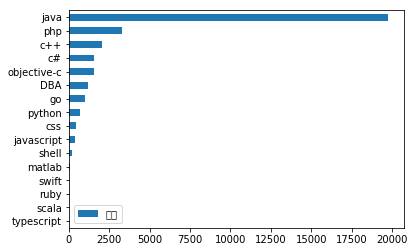

In [12]:
import matplotlib.pyplot as plt
res_df.plot(kind='barh', stacked=True)
plt.show()

In [7]:
sql_job51 = '''
    select industry, name from 51job_position 
'''
job51_df = pd.read_sql(sql_job51, conn)

In [16]:
res = job51_df[True ^ job51_df.industry.isin(['1000-5000人', '5000-10000人', '500-1000人', '少于50人', '150-500人', '50-150人'])]
job51_df.size / 2

2689539.0

In [21]:
g = res.groupby('industry')

In [48]:
irank = g.size().sort_values(ascending=False)[:15]

# 招聘职位数排名前15的行业

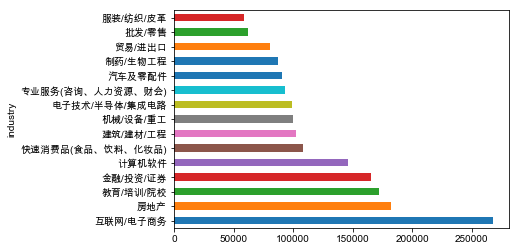

In [49]:
import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
irank.plot(kind='barh', stacked=True)
plt.show()

In [3]:
sql_51job_labels_no_other = '''
    select position_labels from 51job_position where position_labels <> '其他'
'''
sql_51job_labels_other = '''
    select name as position_labels from 51job_position where position_labels = '其他'
'''
job51_position_rank = pd.concat([pd.read_sql(sql_51job_labels_no_other, conn), pd.read_sql(sql_51job_labels_other, conn)])

In [4]:
import numpy as np
res_list = ','.join(job51_position_rank['position_labels']).split(',')
res_def = pd.DataFrame(res_list, index=np.arange(len(res_list)))

In [5]:
res_def = res_def.rename(columns={0:'position_labels'})

In [6]:
res_group = res_def.groupby('position_labels')

In [7]:
# 销售岗
sale_total_num = res_group.size()[False ^ res_group.size().index.str.contains('销售|客户代表')].sum()
# 教师
teacher_total_num = res_group.size()[False ^ res_group.size().index.str.contains('教师|老师')].sum()
# 人事
renshi_total_num = res_group.size()[False ^ res_group.size().index.str.contains('人事')].sum()

In [3]:
res_choose = res_group.size()[True ^ res_group.size().index.str.contains('[教师|老师|销售|客户代表|五险一金|节日福利|双休|立即上岗|应届生|员工旅游|交通补助|培训|出差补贴|话补|加班补助|全勤奖|人事|带薪年假]')]
res_choose['销售'] = sale_total_num 
res_choose['教师'] = teacher_total_num
res_choose['人事'] = renshi_total_num
res_choose.sort_values(ascending=False)[0:100].to_json(orient='index', force_ascii=False)

NameError: name 'res_group' is not defined

In [100]:
sql_lagou_hr = '''
    select publisher_id,real_name,num as self_num from lagou_hr
'''
sql_lagou_recruit_day = '''
    select publisher_id, company_id from lagou_recruit_day group by publisher_id, company_id
'''
sql_lagou_company = '''
    select company_id, full_name, short_name, size, industry, finance_stage, num as total_num from lagou_company
'''
lagou_hr_df = pd.read_sql(sql_lagou_hr, conn)
lagou_recruit_day = pd.read_sql(sql_lagou_recruit_day, conn)
lagou_company = pd.read_sql(sql_lagou_company, conn)

In [101]:
res_lrd_df = pd.merge(lagou_recruit_day, lagou_hr_df, on='publisher_id', how='left')

In [127]:
res_com_df = pd.merge(lagou_company, res_lrd_df, on='company_id', how='left')
res_com_df = res_com_df.set_index('company_id')
res_com_df.head()

,full_name,short_name,size,industry,finance_stage,total_num,publisher_id,real_name,self_num
company_id,,,,,,,,,
49,北京优视米网络科技有限公司,优米网,150-500人,"教育,文化娱乐",初创型(天使轮),4,953.0,宋雪丹,4.0
53,北京创锐文化传媒有限公司,聚美优品,2000人以上,电子商务,上市公司,36,2231747.0,cdhr,34.0
53,北京创锐文化传媒有限公司,聚美优品,2000人以上,电子商务,上市公司,36,6894593.0,张宏宇,2.0
56,深圳市华宇讯科技有限公司,卖座网,500-2000人,"移动互联网,电子商务",成长型(B轮),22,2651482.0,adam,21.0
56,深圳市华宇讯科技有限公司,卖座网,500-2000人,"移动互联网,电子商务",成长型(B轮),22,3462299.0,李诚,1.0


In [124]:
res_g = res_com_df.groupby(['company_id'])

In [140]:
import numpy as np
res_hr_num_df = res_g.size().to_frame().rename(columns={0:'hr_num'})
company_hr_num_df = pd.concat([lagou_company.set_index('company_id'), res_hr_num_df], axis=1)

In [168]:
res_com_hr_rank_df = company_hr_num_df.sort_values('hr_num', ascending=False)
res_com_hr_rank_df = res_com_hr_rank_df.sort_values('total_num', ascending=False)[:100]

# 招聘数量和公司规模的关系

In [171]:
res_com_hr_rank_df.groupby('finance_stage').size().sort_values(ascending=False)

finance_stage
上市公司          23
成长型(B轮)       19
成熟型(D轮及以上)    19
成熟型(C轮)       14
成熟型(不需要融资)    11
成长型(不需要融资)     6
成长型(A轮)        4
初创型(未融资)       3
初创型(天使轮)       1
dtype: int64

In [175]:
pd.DataFrame(res_com_hr_rank_df.set_index('short_name'), columns=['hr_num']).sort_values('hr_num', ascending=False)

,hr_num
short_name,
武汉佰钧成技术有限公司,68
美团点评,59
蚂蚁金服集团,59
百度,32
斗米兼职,31
达内集团,30
橙鹰,30
弘历软件,26
滴滴出行,24
